readings:
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [ ]:
!pip install seaborn

In [28]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Titanic data-set
Can you predict who survived and who did not?

In [29]:
# data
test = pd.read_csv("../data/titanic/test.csv")
train = pd.read_csv("../data/titanic/train.csv")

In [30]:
total = train.isnull().sum().sort_values(ascending=False)
display(train.shape, test.shape)

(891, 12)

(418, 11)

In [ ]:
total

Variable | Meaning
---------|:--------:
Pclass | Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
survival | Survival (0 = No; 1 = Yes)
name | Name
sex | Sex
age | Age
sibsp | Number of Siblings/Spouses Aboard
parch | Number of Parents/Children Aboard
ticket | Ticket Number
fare | Passenger Fare (British pound)
cabin | Cabin
embarked | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat | Lifeboat
body | Body Identification Number
home.dest | Home/Destination


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [32]:
# we have to get rid of the objects somehow:
train[['Name', 'Ticket', 'Cabin']].head()

,Name,Ticket,Cabin
0,"Braund, Mr. Owen Harris",A/5 21171,NaN
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85
2,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123
4,"Allen, Mr. William Henry",373450,NaN


In [33]:
# Name is unique; Cabin hast to many Nans, Ticket is somehow unique too
train = train.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
test = test.drop(['Name', 'Ticket', 'Cabin'], axis = 1)

Next, we replace the string-variables with numeric (integer) variables and fill missing values in age with the most frequent age.

In [34]:
unique_embarked = set(train.Embarked.unique()).union(test.Embarked.unique())
embarked = dict(zip(unique_embarked, list(range(len(unique_embarked)))))
unique_sex = set(train.Sex.unique()).union(test.Sex.unique())
sex = dict(zip(unique_sex, list(range(len(unique_sex)))))

data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked)
    dataset['Sex'] = dataset['Sex'].map(sex)
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mode().values[0])    

not necessary, but we cast our categorical variables to data-type 'category'

In [36]:
categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']
train[categorical] = train[categorical].astype('category')
test[categorical] = test[categorical].astype('category')

In [37]:
categorical

[]

### we fit a RandomForest Classifier

In [38]:
survived = train['Survived']
train = train.drop('Survived', axis=1)
rf = RandomForestClassifier()
rf.fit(train, survived)

RandomForestClassifier()

### The RandomForest Classifier comes with an feature_importances_ attribute

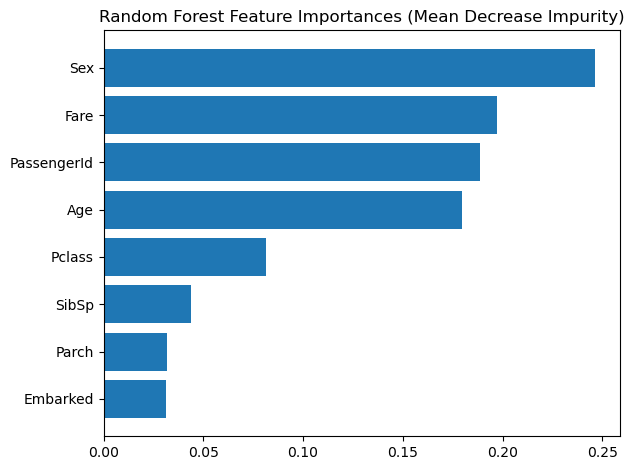

In [39]:
tree_feature_importances = rf.feature_importances_
feature_names = train.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (Mean Decrease Impurity)")
fig.tight_layout()
plt.show()

### Surprise!
Why is passengerId such an important variable?

### Can we make the old PassengerId-variable shine even brighter?

In [40]:
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import StratifiedKFold

encoder = OneHotEncoder(cols = ['Age', 'Sex'])
train_oh = encoder.fit_transform(train)
test_oh = encoder.transform(test)

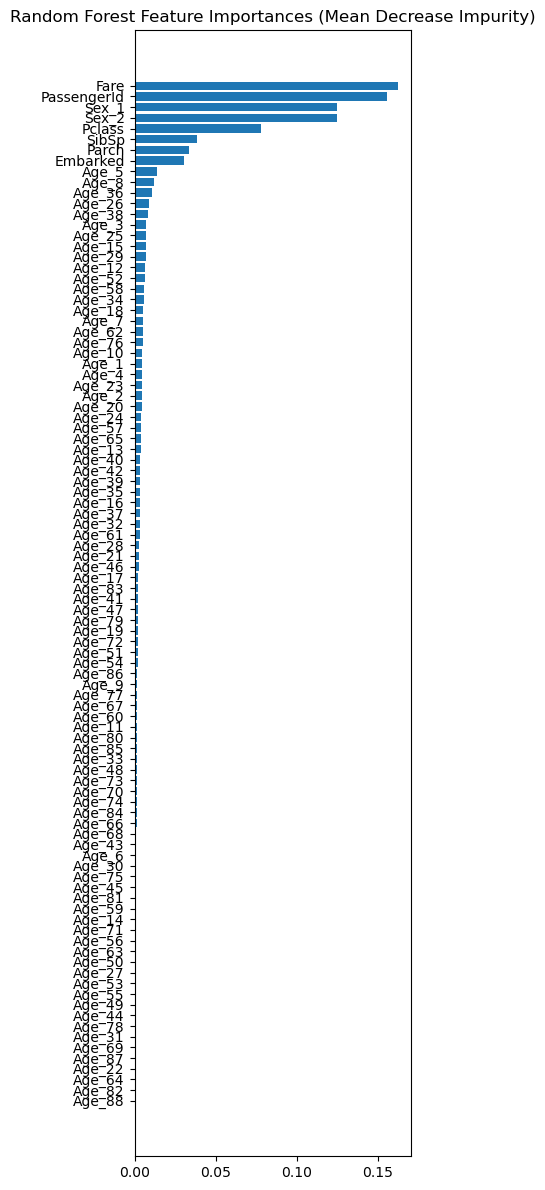

In [41]:
rf = RandomForestClassifier()
rf.fit(train_oh, survived)
tree_feature_importances = rf.feature_importances_
feature_names = train_oh.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(4, 12))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (Mean Decrease Impurity)")
fig.tight_layout()
plt.show()

### Explanation:<br>
The variable Age is one-hot encoded and the importance of the variable is split accross the new 'age'-variables. Hence, the PassengerId becomes even more important.

# Why is the PassengerId so important?
## Gini-coefficient (gini impurity) for splitting variables

\begin{equation*}
\text{gini}=1-\sum_i^J p_i^2 
\end{equation*}
where $i$ is the class index;
The gini impurity measueres the purity of a node. If all elements within one node fall in one class, $p_i=1$ and the impurity is at its minimum.<br>
Gini impurity favours splitting repeatedly on continuous variables and thus cutting out regions of very low impurity. The continuous variable itself might even contain no real information at all (PassengerId).<br>

The build-in feature-importance consists in just summing the reduction in gini-impurity per variable; This is fast, because these statistics are readily available from fitting the trees.

# Permutation variable importance
Here, the variables, one after the other are randomly permutated and the effect on the algorithm-performance is measured. This is done several times per variable to 'bootstrap' the distribution of the reduction.<br>
The variable that affects most the performance is the most important variable.

In [42]:
display(train.head(), survived.head())

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,0,22.0,1,0,7.2500,0
1,2,1,1,38.0,1,0,71.2833,1
2,3,3,1,26.0,0,0,7.9250,0
3,4,1,1,35.0,1,0,53.1000,0
4,5,3,0,35.0,0,0,8.0500,0


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

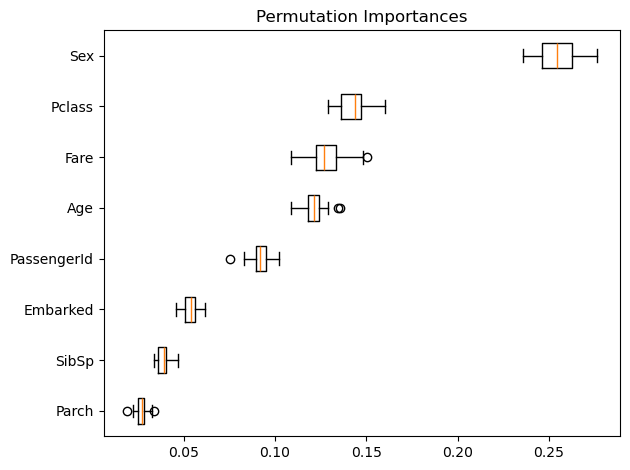

In [43]:
from sklearn.inspection import permutation_importance

rf_model = RandomForestClassifier()
rf_model.fit(train, survived)
result = permutation_importance(rf_model, train, survived,
        n_repeats=30,
        random_state=0)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

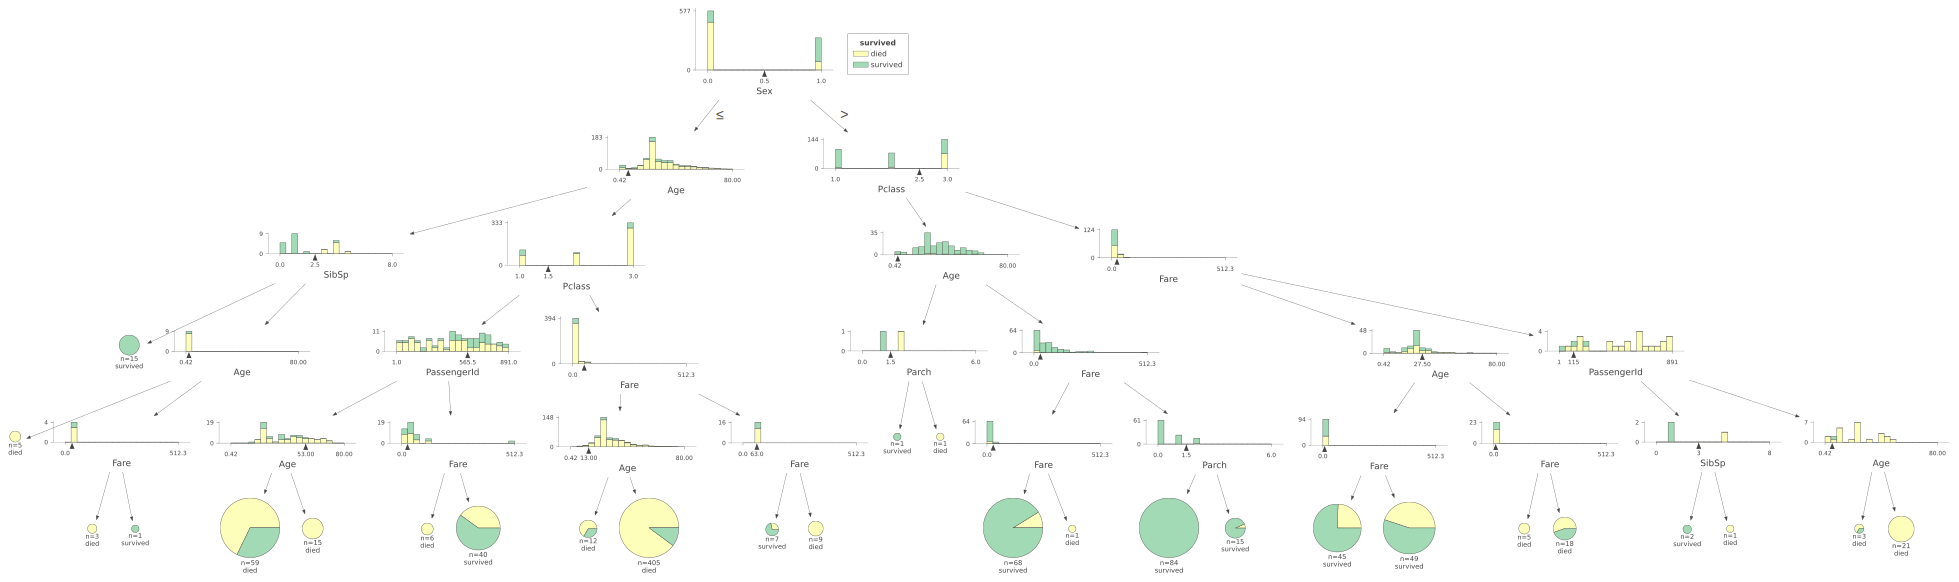

In [44]:
import warnings
warnings.filterwarnings('ignore')

import dtreeviz
from sklearn import tree
from dtreeviz.trees import *

classifier = tree.DecisionTreeClassifier(max_depth=5)  # limit depth of tree
classifier.fit(train, survived)

viz = dtreeviz.model(classifier, 
               train, 
               survived,
               target_name='survived',
               feature_names=train.columns, 
               class_names=["died", "survived"]  # need class_names for classifier
              )  
              
viz.view() 

# experiment
The PassengerId still has a positive variable importance - even with permutation importance.<br>
### How well would a random variable perform?
  - some values are repeating but random
  - all values are unique and random

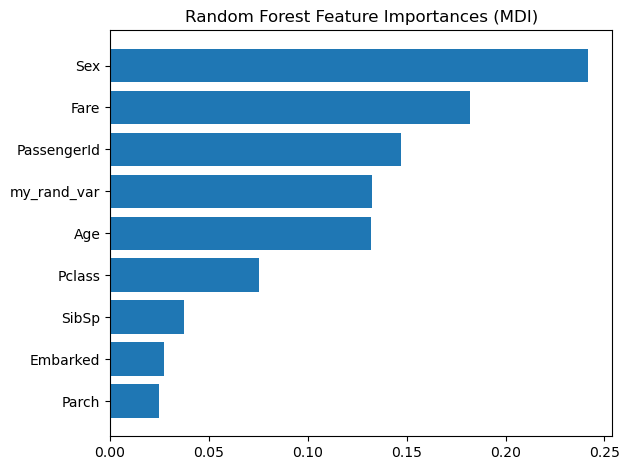

In [45]:
# simple random variable not all values unique (vs. PassengerId)

from numpy.random import randint
train_rand = train.copy()

train_rand['my_rand_var'] = randint(0, train.shape[0], train.shape[0])

rf_rand = RandomForestClassifier()
rf_rand.fit(train_rand, survived)
tree_feature_importances = rf_rand.feature_importances_
feature_names = train_rand.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

### Cardinality of Variable in relation to number of observations
If the ratio is 1.0, that means that we have as many different values in the variable as there are observations. The number of possible splits that just randomly lead to pure nodes is very high.

In [51]:
display(len(train_rand.Age.unique())/train.shape[0], len(train_rand.my_rand_var.unique())/train.shape[0],
       len(train_rand.PassengerId.unique())/train.shape[0])

0.09876543209876543

0.6240179573512907

1.0

## New experiment: artificial variables, all values unique and even sorted

When we repeatedly execute the cell below, in most cases the variable 'my_unique_rand_var' has a higher feature_importance than the 'my_unique_rand_var_sorted' variable.<br>
Why is this?<br>
Values of both variables are unique. There should be no sorting in the target-variable within the data-frame.

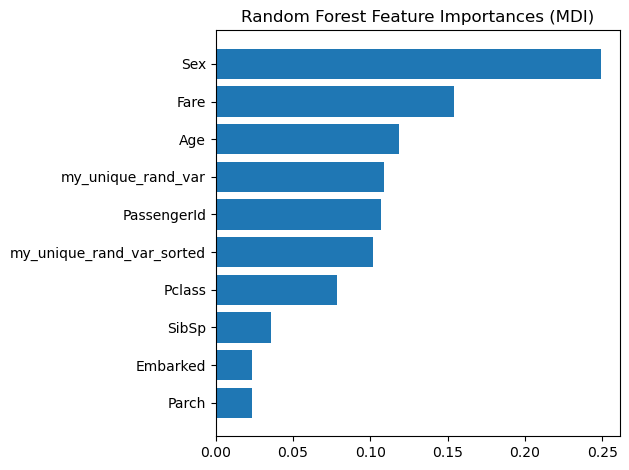

In [52]:
# simple random variable all values unique (vs. PassengerId)

from numpy.random import choice
train_rand_all_unique = train.copy()

train_rand_all_unique['my_unique_rand_var'] = choice(np.arange(train.shape[0]), train.shape[0], replace=False)
train_rand_all_unique['my_unique_rand_var_sorted'] = np.arange(train.shape[0])

rf_rand_all_unique = RandomForestClassifier()
rf_rand_all_unique.fit(train_rand_all_unique, survived)
tree_feature_importances = rf_rand_all_unique.feature_importances_
feature_names = train_rand_all_unique.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

### Explanation: 
PassengerId and 'my_unique_rand_var_sorted' contain basically the same information. Both only have unique values and the dataframe is sorted by PassengerId. This is why the share some feature importance and have a slightly smaller contribution then my_unique_rand_var that is uncorrelated to the two other variables. The last fact can also be seen in a correlation plot.

### However,
the contribution of the PassengerId is still higher than what would have been expected if the variable merely contained noise. As suggested by one of the students, ticket numbers such as ‘1’, ‘2’, or ‘3’ could have been considered prestigious. These tickets might have been purchased by wealthy individuals who also belonged to Passenger Class 1, which is associated with higher survival rates. So, there could be some information in the lower range of the PassengerId.

<Axes: >

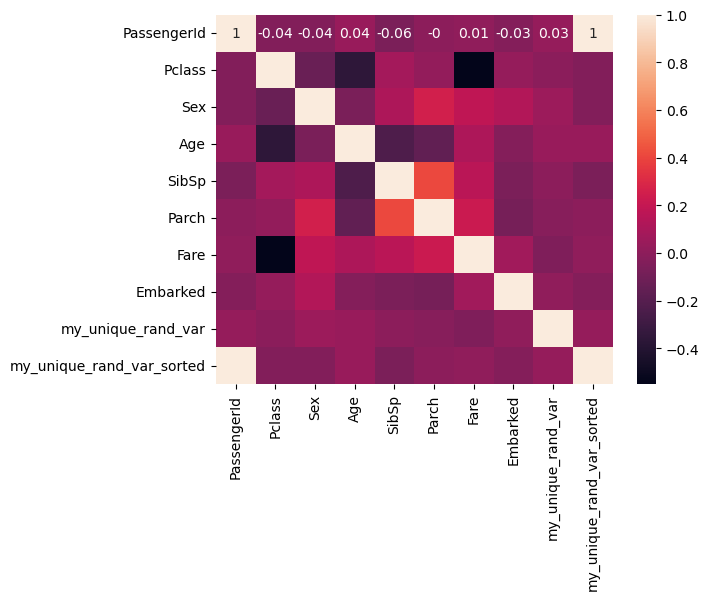

In [53]:
sns.heatmap(np.round(train_rand_all_unique.corr(), 2), annot=True)

# Canary Variables
An artificially generated variable can help here for the interpretation of the variable importance; Variables having a feature importance below the one of the artificial variable should not be interpreted.

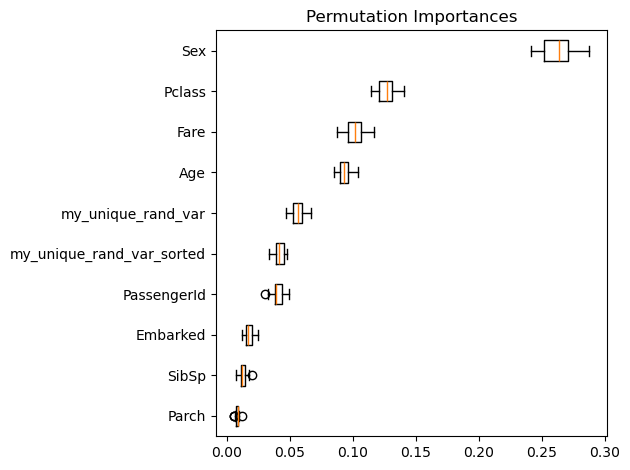

In [54]:
from sklearn.inspection import permutation_importance

rf_model = RandomForestClassifier()
rf_model.fit(train_rand_all_unique, survived)
result = permutation_importance(rf_model, train_rand_all_unique, survived,
        n_repeats=30,
        random_state=0)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=train_rand_all_unique.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()